<a href="https://colab.research.google.com/github/bharathts1507/TSAI-Assignments-EVA4/blob/master/TSAI_EVA4_S5_Model_1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Method 1: Using Light model to acheieve the target

#Target : 
- Lesser parameters around 10K
- Test Accuracy ~99%
- ~15 Epochs 

#Results: 
- Parameters used : 12716
- Train Accuracy: 99.07%
- Test Accuracy : 98.72%

#Analysis - Observation :
- Less number of parameters requires more epochs to reach higher accuracy
- Could achieve higher accuracy with more parameters with few epochs.


In [0]:
#import necessary libraries

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
#Using data with normalized values and converting images into Tensor form
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [3]:
#Download and setup train and test datasets
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [4]:
#Keep seed constant to reproduce same results
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)


CUDA Available? False


In [0]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


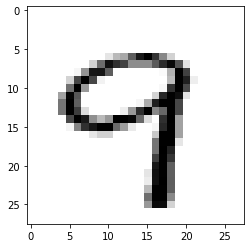

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


In [0]:
#Create Architecture of model - layers, parameters and channels 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            
            nn.ReLU()
        ) # output_size = 26, RF = 3x3, step=1

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), 
            
            nn.ReLU()
        ) # output_size = 24, RF = 5x5, step=1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),         
            nn.ReLU()
        ) # output_size = 22, RF=7x7, step=1

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11, RF = 7x7, step=2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 11, RF = 7, step=2

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 9, RF= 11, step=2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7, RF=15, step=2

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7, RF=15, step=2
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1, RF=27, step=2

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
              ReLU-2           [-1, 12, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           1,728
              ReLU-4           [-1, 16, 24, 24]               0
            Conv2d-5           [-1, 20, 22, 22]           2,880
              ReLU-6           [-1, 20, 22, 22]               0
         MaxPool2d-7           [-1, 20, 11, 11]               0
            Conv2d-8           [-1, 10, 11, 11]             200
              ReLU-9           [-1, 10, 11, 11]               0
           Conv2d-10             [-1, 10, 9, 9]             900
             ReLU-11             [-1, 10, 9, 9]               0
           Conv2d-12             [-1, 20, 7, 7]           1,800
             ReLU-13             [-1, 20, 7, 7]               0
           Conv2d-14             [-

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.06142386421561241 Batch_id=937 Accuracy=68.10: 100%|██████████| 938/938 [01:22<00:00, 11.33it/s]
Loss=0.19795775413513184 Batch_id=1 Accuracy=94.53:   0%|          | 2/938 [00:00<01:26, 10.85it/s]


Test set: Average loss: 0.1136, Accuracy: 9628/10000 (96.28%)

EPOCH: 1


Loss=0.06000199541449547 Batch_id=937 Accuracy=96.69: 100%|██████████| 938/938 [01:26<00:00, 10.85it/s]
Loss=0.07398120313882828 Batch_id=1 Accuracy=96.09:   0%|          | 2/938 [00:00<01:26, 10.78it/s]


Test set: Average loss: 0.0700, Accuracy: 9780/10000 (97.80%)

EPOCH: 2


Loss=0.027844926342368126 Batch_id=937 Accuracy=97.65: 100%|██████████| 938/938 [01:29<00:00, 10.48it/s]
Loss=0.02641717717051506 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:21, 11.52it/s]


Test set: Average loss: 0.0614, Accuracy: 9800/10000 (98.00%)

EPOCH: 3


Loss=0.11142326891422272 Batch_id=937 Accuracy=98.06: 100%|██████████| 938/938 [01:28<00:00, 10.63it/s]
Loss=0.08486458659172058 Batch_id=1 Accuracy=97.66:   0%|          | 1/938 [00:00<01:34,  9.92it/s]


Test set: Average loss: 0.0611, Accuracy: 9804/10000 (98.04%)

EPOCH: 4


Loss=0.033615171909332275 Batch_id=937 Accuracy=98.37: 100%|██████████| 938/938 [01:26<00:00, 10.80it/s]
Loss=0.012325016781687737 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:20, 11.59it/s]


Test set: Average loss: 0.0478, Accuracy: 9859/10000 (98.59%)

EPOCH: 5


Loss=0.04503483697772026 Batch_id=937 Accuracy=98.48: 100%|██████████| 938/938 [01:26<00:00, 11.90it/s]
Loss=0.007538079749792814 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:21, 11.44it/s]


Test set: Average loss: 0.0531, Accuracy: 9822/10000 (98.22%)

EPOCH: 6


Loss=0.020315654575824738 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [01:26<00:00, 11.98it/s]
Loss=0.017644686624407768 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:24, 11.06it/s]


Test set: Average loss: 0.0438, Accuracy: 9859/10000 (98.59%)

EPOCH: 7


Loss=0.01406590361148119 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [01:24<00:00, 12.07it/s]
Loss=0.007053025532513857 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:25, 10.97it/s]


Test set: Average loss: 0.0480, Accuracy: 9849/10000 (98.49%)

EPOCH: 8


Loss=0.04907967895269394 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [01:23<00:00, 11.18it/s]
Loss=0.019448915496468544 Batch_id=1 Accuracy=97.66:   0%|          | 2/938 [00:00<01:24, 11.03it/s]


Test set: Average loss: 0.0462, Accuracy: 9847/10000 (98.47%)

EPOCH: 9


Loss=0.04214448109269142 Batch_id=937 Accuracy=98.85: 100%|██████████| 938/938 [01:21<00:00, 12.17it/s]
Loss=0.011951148509979248 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:20, 11.62it/s]


Test set: Average loss: 0.0438, Accuracy: 9860/10000 (98.60%)

EPOCH: 10


Loss=0.021609028801321983 Batch_id=937 Accuracy=98.91: 100%|██████████| 938/938 [01:21<00:00, 12.47it/s]
Loss=0.0021134326234459877 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:21, 11.43it/s]


Test set: Average loss: 0.0431, Accuracy: 9857/10000 (98.57%)

EPOCH: 11


Loss=0.013135828077793121 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [01:19<00:00, 12.92it/s]
Loss=0.01106030773371458 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:19, 11.83it/s]


Test set: Average loss: 0.0467, Accuracy: 9853/10000 (98.53%)

EPOCH: 12


Loss=0.08915366977453232 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [01:18<00:00, 12.71it/s]
Loss=0.04729156568646431 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:15, 12.47it/s]


Test set: Average loss: 0.0473, Accuracy: 9851/10000 (98.51%)

EPOCH: 13


Loss=0.0007091049919836223 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [01:18<00:00, 13.44it/s]
Loss=0.023254523053765297 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:14, 12.55it/s]


Test set: Average loss: 0.0463, Accuracy: 9868/10000 (98.68%)

EPOCH: 14


Loss=0.0014827065169811249 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [01:16<00:00, 12.92it/s]
Loss=0.005941315088421106 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:16, 12.24it/s]


Test set: Average loss: 0.0492, Accuracy: 9856/10000 (98.56%)

EPOCH: 15


Loss=0.004381985403597355 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [01:17<00:00, 13.37it/s]
Loss=0.006503739394247532 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:20, 11.64it/s]


Test set: Average loss: 0.0440, Accuracy: 9871/10000 (98.71%)

EPOCH: 16


Loss=0.017552519217133522 Batch_id=937 Accuracy=99.23: 100%|██████████| 938/938 [01:17<00:00, 12.65it/s]
Loss=0.0031736576929688454 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:18, 11.87it/s]


Test set: Average loss: 0.0686, Accuracy: 9814/10000 (98.14%)

EPOCH: 17


Loss=0.004888592287898064 Batch_id=937 Accuracy=99.27: 100%|██████████| 938/938 [01:17<00:00, 12.77it/s]
Loss=0.049381379038095474 Batch_id=1 Accuracy=96.88:   0%|          | 2/938 [00:00<01:14, 12.51it/s]


Test set: Average loss: 0.0477, Accuracy: 9861/10000 (98.61%)

EPOCH: 18


Loss=0.003757425583899021 Batch_id=937 Accuracy=99.32: 100%|██████████| 938/938 [01:17<00:00, 13.50it/s]
Loss=0.0037833936512470245 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:18, 11.93it/s]


Test set: Average loss: 0.0469, Accuracy: 9867/10000 (98.67%)

EPOCH: 19


Loss=0.008300291374325752 Batch_id=937 Accuracy=99.36: 100%|██████████| 938/938 [01:17<00:00, 12.51it/s]



Test set: Average loss: 0.0461, Accuracy: 9876/10000 (98.76%)



Text(0.5, 1.0, 'Test Accuracy')

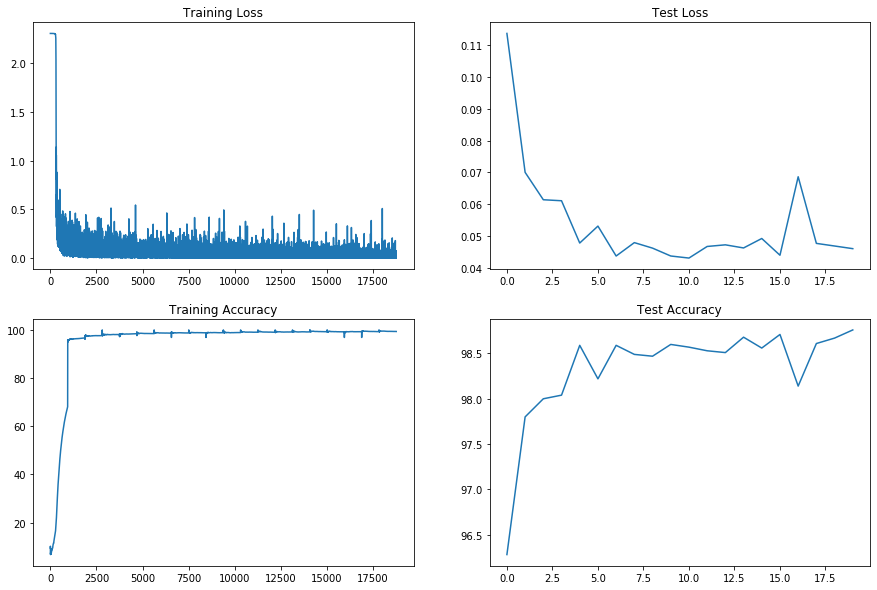

In [11]:
 fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")